In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix,
    get_deps_from_inverse_sig
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data by Passing in Edge List

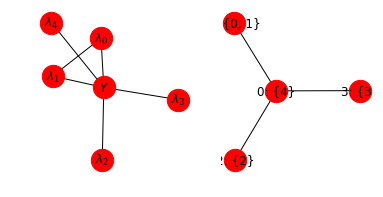

In [34]:
M = 5
N = 1000 #not used
MAX_CLIQUE_SIZE = 2
NUM_CLIQUES = 1
K = 2
HIGHER_ORDER_CLIQUES = False

# Set Graph Structure
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()


#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

#Generate Data
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()
mu = data.get_mu()

$$(S-L,\Sigma_O) + \lambda_n(\gamma ||S||_1 + ||L||_*)$$

In [52]:
import cvxpy as cp
import scipy as sp

#bad code
O = 1/2*(sigma_O+sigma_O.T)
O_root = np.real(sp.linalg.sqrtm(O))

# low-rank matrix
L = cp.Variable([M,M], symmetric=True)

# sparse matrix
S = cp.Variable([M,M], symmetric=True)

# S-L matrix
R = cp.Variable([M,M], symmetric=True)

#reg params
lam = 1e-10
gamma = 1e-10

objective = cp.Minimize(0.5*(cp.norm(R*O_root, 'fro')**2) - cp.trace(R) + lam*(gamma*cp.pnorm(S,1) + cp.norm(L, "nuc")))
constraints = [R == S - L, L>>0]

prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False)
opt_error = prob.value

J_hat = S.value

In [53]:
S.value

array([[ 6.00784542e+00,  1.12390261e-14, -4.84954506e-15,
         4.44916356e-15,  1.95529010e-15],
       [ 1.12390261e-14,  6.00784542e+00, -1.37028141e-14,
         2.18681356e-14,  1.65815096e-14],
       [-4.84954506e-15, -1.37028141e-14,  6.00784542e+00,
        -1.14771234e-14,  7.90078168e-15],
       [ 4.44916356e-15,  2.18681356e-14, -1.14771234e-14,
         6.00784542e+00,  9.21007737e-15],
       [ 1.95529010e-15,  1.65815096e-14,  7.90078168e-15,
         9.21007737e-15,  6.00784542e+00]])

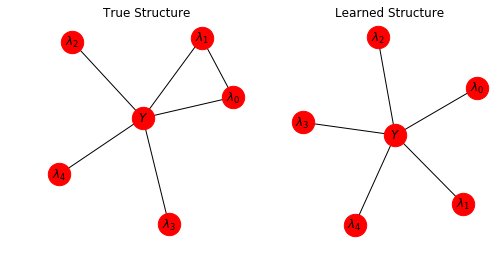

In [54]:
deps_hat = get_deps_from_inverse_sig(J_hat, thresh=1e-3) 
deps = []
for i,j in deps_hat:
    if i < j:
        deps.append((i,j))
        
deps_graph_est = DependenciesGraph(M, deps)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()

In [49]:
J_hat

array([[ 5.20424353e+00,  2.56196362e-16,  1.81604094e-17,
         3.14274042e-16, -1.03302145e-16],
       [ 8.64877754e-16,  5.20424353e+00,  8.59447139e-16,
        -1.87978073e-15, -6.20021062e-16],
       [-8.85015064e-17,  6.64633212e-15,  5.20424353e+00,
        -2.02663789e-15, -3.05103321e-15],
       [ 1.07247554e-15, -6.19437541e-15, -4.13116407e-15,
         5.20424353e+00, -4.25657545e-15],
       [ 1.17337291e-16,  3.01743654e-15,  3.19820255e-15,
         7.19505383e-15,  5.20424353e+00]])

**Old Code**

In [7]:
# import cvxpy as cp

# # low-rank matrix
# L = cp.Variable([M,M], PSD=True)

# # sparse matrix
# S = cp.Variable([M,M])

# #reg params
# lam = 1/np.sqrt(M)
# gamma = 1e-8


# reg_loss = lam*(gamma*cp.pnorm(S,1) + cp.norm(L, "nuc"))
# trace_loss = 0.5*(cp.trace((S-L)*sigma_O*(S-L))) - cp.trace((S-L))
# objective = cp.Minimize(reg_loss)

# #constraints are okay
# constraint_diff = [S-L >> 0]
# constraints = constraint_diff

# prob = cp.Problem(objective, constraints)
# result = prob.solve(verbose=False)
# opt_error = prob.value

# J_hat = S.value